In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import warnings
import torch 
import optuna 
from itertools import product
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor, plot_importance
from pytorch_tabnet.tab_model import TabNetRegressor 

### Environment & Library Requirements
- **Python**: 3.9.21
- **numpy**: 2.0.2
- **pandas**: 2.2.3
- **matplotlib**: 3.9.4
- **scikit-learn**: 1.6.1
- **optuna**: 4.3.0
- **torch (PyTorch)**: 2.7.0
- **pytorch-tabnet**: 4.1.0
- **keras-tuner**: 1.4.7 (optional, if used earlier)
- **jupyterlab**: 4.4.2 (if using notebooks)
- **Python**: 3.9.21
- **Seaborn**: 0.13.2
- **catboost**: 1.2.8
- **xgboost**: 3.0.1

### Group Component 1

#### Premilinary Changes to Data

We have not changed anything from stage 1 of the cleaned dataset here.

#### Data Split for Train and Test Sets

We split the dataset into the training set (70%) and the test set (30%). This is a compromise choice between training and assessment, because the model cannot learn the pattern when the training set is too small, and the evaluation results will be unstable when the test set is too small. Then we add a random state (= 42 here) to guarantee the same results in each running time. Here, the validation set is not included because it will be split in the cross-validation method we chose.


Stratified sampling is not used in this study, because we predict price, which is a continuous target variable, while stratified sampling is more suitable for classification tasks with discrete class labels. Then, we checked the distribution of the target variable Price and found it to be moderately right-skewed, which is typical for second-hand vehicle prices. However, the skewness is moderate, and there are no extremely influential outliers. Therefore, we did not apply any transformation or outlier removal, because the distribution is reasonable and typical for this task, and the evaluation metrics used are robust to this skewness.


### Set up

Note: 

Predict "Price"

metrics: RMSE, MAE, R^2

use repeated k-fold cross-validation

split the dataset into training set(70%), test set(30%)

random state = 42

In [2]:
# read the file
df = pd.read_csv("Group197_FinalCleanData.csv", index_col=0)

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
    
# y = "Price"，others are features in x
X = df.drop("Price", axis=1)
y = df["Price"]

In [3]:
# split training set(70%), test set(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

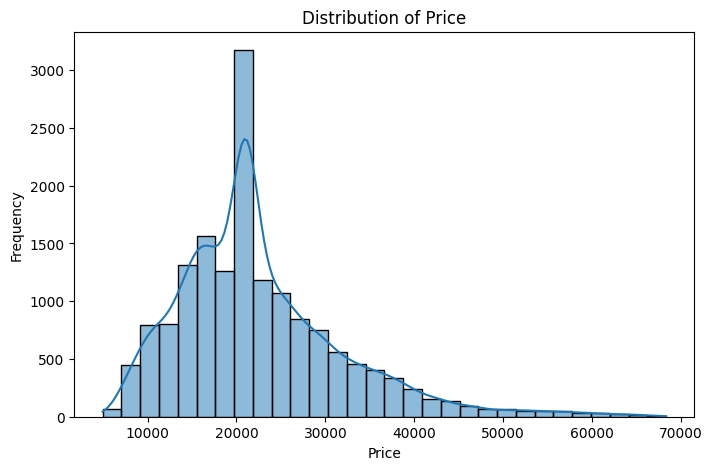

In [4]:
# check price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

### **End of Group Component 1**

### individual component

#### unikey: awan0950 (CatBoost)

#### Initial model

In [5]:
# select the categorical features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [6]:
# Repeated K-Fold CV settings
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

In [7]:
# train and evaluate models
def evaluate_model(model, X_train, y_train, name="model"):
    mae_scores = []
    rmse_scores = []
    r2_scores = []

    for train_idx, val_idx in rkf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        mae_scores.append(mean_absolute_error(y_val, preds))
        rmse_scores.append(root_mean_squared_error(y_val, preds))
        r2_scores.append(r2_score(y_val, preds))

    print(f"【{name}】")
    print(f"average MAE:  {np.mean(mae_scores):.2f}")
    print(f"average RMSE: {np.mean(rmse_scores):.2f}")
    print(f"average R^2:  {np.mean(r2_scores):.4f}")
    print("-" * 40)

In [8]:
# initial model
init_model = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    cat_features=categorical_features,
    verbose=0,
    random_seed=42 
)

#### Hyperparameter tuning

In [9]:
# define parameter search space
param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.03, 0.05, 0.07],
    'l2_leaf_reg': [1, 3, 5]
}

In [10]:
# all parameter combinations
param_combinations = list(product(param_grid['depth'],
                                  param_grid['learning_rate'],
                                  param_grid['l2_leaf_reg']))

In [11]:
# hyperparameter tuning according to MAE
results = []

# go through all the combinations
for depth, lr, l2 in param_combinations:
    mae_scores = []

    for train_idx, val_idx in rkf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = CatBoostRegressor(
            iterations=100,
            learning_rate=lr,
            depth=depth,
            l2_leaf_reg=l2,
            cat_features=categorical_features,
            verbose=0,
            random_seed=42
        )

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        mae = mean_absolute_error(y_val, preds)
        mae_scores.append(mae)

    avg_mae = np.mean(mae_scores)
    results.append({
        'depth': depth,
        'learning_rate': lr,
        'l2_leaf_reg': l2,
        'MAE': avg_mae
    })

# check the result
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAE')
print(results_df)

    depth  learning_rate  l2_leaf_reg          MAE
15      8           0.07            1  4827.928978
16      8           0.07            3  4832.491043
12      8           0.05            1  4833.503032
14      8           0.05            5  4835.149012
13      8           0.05            3  4835.435738
17      8           0.07            5  4835.691270
9       8           0.03            1  4850.087562
10      8           0.03            3  4855.313638
11      8           0.03            5  4856.523434
6       6           0.07            1  4856.542205
7       6           0.07            3  4857.444184
8       6           0.07            5  4861.368917
4       6           0.05            3  4862.738170
3       6           0.05            1  4863.172155
5       6           0.05            5  4867.059277
0       6           0.03            1  4887.475572
2       6           0.03            5  4892.212347
1       6           0.03            3  4893.291574


#### final tuned model

Here I choose the parameter combination with the minimum MAE for the final model

In [13]:
# final model (after hyperparameter tuning)
tuned_model_MAE = CatBoostRegressor(
    iterations=100,
    learning_rate=0.07,
    depth=8,
    l2_leaf_reg=1,
    cat_features=categorical_features,
    verbose=0
)

In [14]:
# evaluate results for those two models
evaluate_model(init_model, X_test, y_test, name="initial model")
evaluate_model(tuned_model_MAE, X_test, y_test, name="final model")

【initial model】
average MAE:  4887.58
average RMSE: 6420.60
average R^2:  0.5344
----------------------------------------
【final model】
average MAE:  4855.83
average RMSE: 6419.98
average R^2:  0.5344
----------------------------------------


#### polts

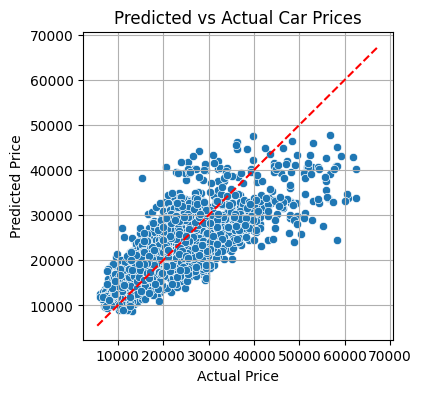

In [19]:
# Predicted vs Actual Plot
plt.figure(figsize=(4,4))
sns.scatterplot(x=y_val, y=preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # expected line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Car Prices")
plt.grid(True)
plt.show()

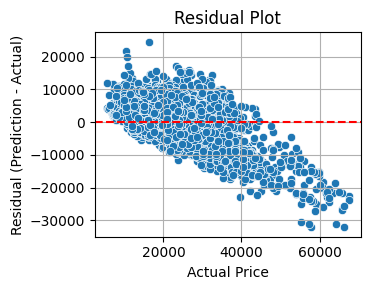

In [27]:
# residual plot
preds = model.predict(X_test)
residuals = preds - y_test

plt.figure(figsize=(4, 3))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Residual (Prediction - Actual)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


### **End of Individual Component - awan0950 (CatBoost)**

### unikey：yiwu0182（XGboost）

#### LabelEncoder
XGBoost is a tree-based model, so it does not require one-hot encoding. Label encoding is sufficient and more efficient for handling categorical features.

In [28]:
# Label encode categorical variables
cat_cols = X_train.select_dtypes(include='object').columns # Identify all categorical columns
encoders = {} # Dictionary to store encoders for each column
for col in cat_cols: 
    le = LabelEncoder()# Initialize a LabelEncoder instance
    X_train[col] = le.fit_transform(X_train[col]) # Fit encoder on training data and transform
    X_test[col] = le.transform(X_test[col]) # Apply the same encoder to the test data
    encoders[col] = le  # Store the encoder in case reverse transformation

#### Hyperparameter Tuning with Repeated K-Fold Cross-Validation

In [29]:
# Initialize a default XGBoost regressor model
xgb = XGBRegressor(random_state=42)

# Define the repeated k-fold cross-validation strategy (5 folds, repeated 3 times)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# Define the hyperparameter search space for tuning
param_grid = {
    'max_depth': [3, 5], # Maximum depth of each tree
    'learning_rate': [0.05, 0.1], # Step size shrinkage to prevent overfitting
    'n_estimators': [100, 200], # Number of boosting rounds
    'subsample': [0.8, 1.0], # Fraction of training data to use for each tree
    'colsample_bytree': [0.8, 1.0] # Fraction of features to use when building each tree
}

# Grid search with CV
# RMSE is used as the evaluation metric
grid = GridSearchCV(estimator=xgb, 
                    param_grid=param_grid, 
                    cv=cv,
                    scoring='neg_root_mean_squared_error', # Use negative RMSE for compatibility
                    n_jobs=-1) # Utilize all available CPU cores for parallel processing

# Fit the model with cross-validation
grid.fit(X_train, y_train)

# Print the best hyperparameters and corresponding cross-validated RMSE score
print("Best Parameters:", grid.best_params_)
print("Best CV Score (neg RMSE):", grid.best_score_) # Convert negative RMSE back to positive
print("Best CV RMSE:", -grid.best_score_) # Extract the best XGBoost model
best_model = grid.best_estimator_
print(best_model)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score (neg RMSE): -6258.079459156532
Best CV RMSE: 6258.079459156532
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)


#### Initial vs Optimized Model Evaluation

In [30]:
# Train an initial XGBoost model using default hyperparameters
initial_model = XGBRegressor(random_state=42)
initial_model.fit(X_train, y_train)

# Predict on the test set using the initial model
y_pred_initial = initial_model.predict(X_test)

# Evaluate initial model performance using standard regression metrics
initial_mae = mean_absolute_error(y_test, y_pred_initial)
initial_rmse = np.sqrt(mean_squared_error(y_test, y_pred_initial))
initial_r2 = r2_score(y_test, y_pred_initial)

# Use the best model found from hyperparameter tuning (GridSearchCV)
final_model = grid.best_estimator_

# Predict on the test set using the tuned model
y_pred_final = final_model.predict(X_test)

# Evaluate final model performance
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)

# Print and compare evaluation results
print("initial model:")
print(f"average MAE:  {initial_mae:.2f}")
print(f"average RMSE: {initial_rmse:.2f}")
print(f"average R^2:  {initial_r2:.4f}")

print("final model:")
print(f"average MAE:  {final_mae:.2f}")
print(f"average RMSE: {final_rmse:.2f}")
print(f"average R^2:  {final_r2:.4f}")

initial model:
average MAE:  4903.50
average RMSE: 6471.21
average R^2:  0.5283
final model:
average MAE:  4770.90
average RMSE: 6223.66
average R^2:  0.5637


#### Predicted vs Actual Prices

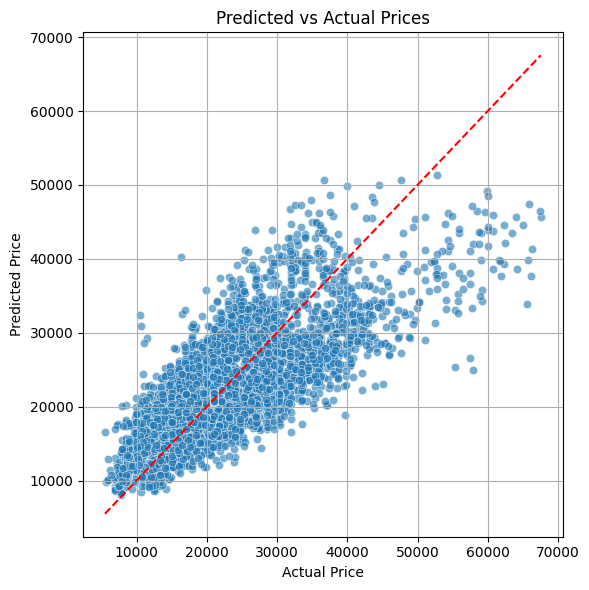

In [31]:
# Plot predicted values against actual values
plt.figure(figsize=(6, 6))

# Create a scatterplot of actual vs predicted prices
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.6)

# Plot a reference diagonal line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

# Label the axes and plot
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

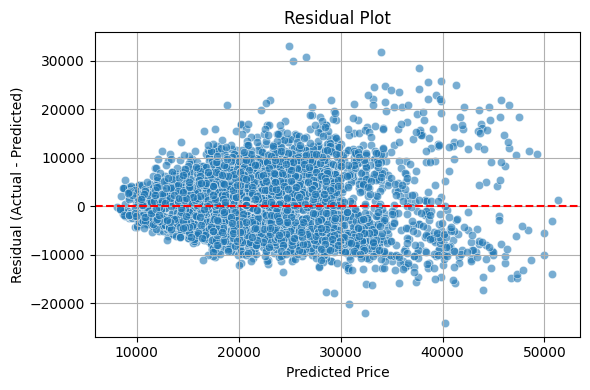

In [32]:
# Calculate residuals (actual - predicted values)
residuals = y_test - y_pred_final

# Create a scatterplot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.6)

# Add a horizontal line at y=0 for reference
plt.axhline(0, color='red', linestyle='--')

# Label the axes
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Feature Importance from Tuned XGBoost Model

<Figure size 1000x600 with 0 Axes>

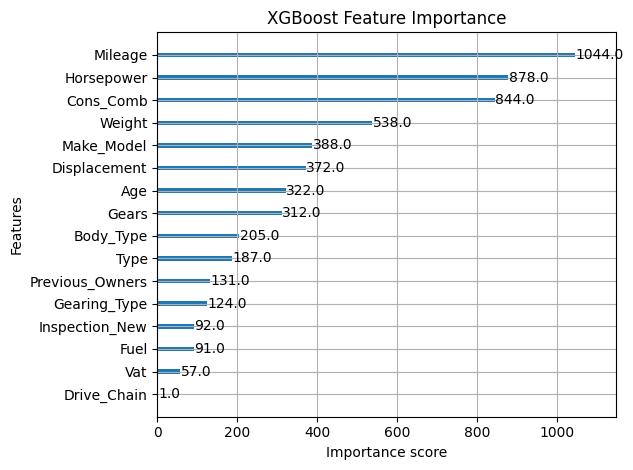

In [33]:
# Plot feature importance for the tuned XGBoost model
plt.figure(figsize=(10, 6))

# Display importance scores for each feature
plot_importance(final_model)

# Add plot title and layout formatting
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

### **End of Individual Component - yiwu0182 (XGBoost)**

### Tabnet Deep Learning Model Code

### Unikey:tche0080

#### Data Pre-processing:

In [34]:
# 1. Load the cleaned dataset and set the first column as index
df = pd.read_csv("Group197_FinalCleanData.csv", index_col=0)

# 2. Split the dataset into features (X) and target variable (y)
X = df.drop("Price", axis=1)  # Features: all columns except "Price"
y = df["Price"]               # Target: the column to predict

In [35]:
# 3. Standardize numeric features to have mean=0 and std=1
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 4. Normalize the target variable (Price) to range [0, 1]
y = (y - y.min()) / (y.max() - y.min())


In [36]:
# 5. Encode categorical features using Label Encoding
# Identify all categorical columns (object dtype)
categorical_cols = X.select_dtypes(include=["object"]).columns

# Initialize label encoder
encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_cols:
    X[col] = encoder.fit_transform(X[col])


In [37]:
# 6. Convert DataFrames to NumPy arrays (float32 is required for TabNet)
X_np = X.values.astype(np.float32)                   # Features array
y_np = y.values.reshape(-1, 1).astype(np.float32)    # Target array reshaped to 2D

In [38]:
# 7. Split data into training and test sets (70% train / 30% test)

X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.3, random_state=42
)

# Print the shape of the resulting splits
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (11218, 16), Test shape: (4808, 16)


In [39]:
# 8. Prepare training setup

# 8.1 Suppress specific non-critical warnings from TabNet
warnings.filterwarnings("ignore", message="Best weights from best epoch are automatically used!")
warnings.filterwarnings("ignore", message="Device used : cpu")

# 8.2 Ensure training data is in NumPy format (float32 for TabNet)
y_train_np = y_train.reshape(-1, 1) if not hasattr(y_train, "values") else y_train.values.reshape(-1, 1)
X_train_np = X_train if not hasattr(X_train, "values") else X_train.values

# 8.3 Initialize Repeated K-Fold Cross-Validation (3 folds, 1 repeat)
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)




#### Initial Model Development and Evaluation:

In [40]:
# 1. Define fixed parameters manually (initial model, no tuning)
params = {
    "n_d": 16,
    "n_a": 16,
    "n_steps": 5,
    "gamma": 1.5,
    "lambda_sparse": 1e-3
}

model = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-2),  # fixed learning rate
    **params
)

model.fit(
    X_train=X_train_np,
    y_train=y_train_np,
    eval_set=[(X_test, y_test)], 
    eval_metric=["mae", "rmse"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
)

# Predictions and metrics
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("Initial Model Metrics (No Tuning):")
print(f"  MAE : {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²  : {r2:.4f}")

epoch 0  | loss: 2.76587 | val_0_mae: 1.37435 | val_0_rmse: 1.76874 |  0:00:00s
epoch 1  | loss: 0.32519 | val_0_mae: 0.97961 | val_0_rmse: 1.29923 |  0:00:01s
epoch 2  | loss: 0.1089  | val_0_mae: 0.39467 | val_0_rmse: 0.50145 |  0:00:02s
epoch 3  | loss: 0.06112 | val_0_mae: 0.22784 | val_0_rmse: 0.30074 |  0:00:02s
epoch 4  | loss: 0.04079 | val_0_mae: 0.19018 | val_0_rmse: 0.2659  |  0:00:03s
epoch 5  | loss: 0.03248 | val_0_mae: 0.13984 | val_0_rmse: 0.18891 |  0:00:04s
epoch 6  | loss: 0.02737 | val_0_mae: 0.13193 | val_0_rmse: 0.1767  |  0:00:05s
epoch 7  | loss: 0.02375 | val_0_mae: 0.11937 | val_0_rmse: 0.16001 |  0:00:05s
epoch 8  | loss: 0.02258 | val_0_mae: 0.11016 | val_0_rmse: 0.14767 |  0:00:06s
epoch 9  | loss: 0.02142 | val_0_mae: 0.10703 | val_0_rmse: 0.14589 |  0:00:07s
epoch 10 | loss: 0.01981 | val_0_mae: 0.10304 | val_0_rmse: 0.13706 |  0:00:08s
epoch 11 | loss: 0.01965 | val_0_mae: 0.10314 | val_0_rmse: 0.1378  |  0:00:09s
epoch 12 | loss: 0.01918 | val_0_mae: 0.

#### Model Optimisation:

In [9]:
# 9. Define Optuna objective function for hyperparameter tuning
def tabnet_model(trial):
    # 9.1 Define hyperparameter search space
    params = {
        "n_d": trial.suggest_categorical("n_d", [8, 16, 32, 64]),             # Decision layer size
        "n_a": trial.suggest_categorical("n_a", [8, 16, 32, 64]),             # Attention layer size
        "n_steps": trial.suggest_int("n_steps", 3, 5),                       # Number of decision steps
        "gamma": trial.suggest_float("gamma", 1.0, 2.0),                      # Feature reuse coefficient
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-5, 1e-1),    # Sparsity regularization
        "optimizer_params": dict(lr=trial.suggest_float("lr", 1e-3, 1e-1, log=True)),# Learning rate
        "mask_type": trial.suggest_categorical("mask_type", ["sparsemax", "entmax"])
    }

    # 9.2 Store metrics in list
    mae_scores = []
    rmse_scores = []
    r2_scores = []

    # 9.3 Cross-validation loop
    for train_idx, valid_idx in rkf.split(X_train_np):
        X_tr, X_val = X_train_np[train_idx], X_train_np[valid_idx]
        y_tr, y_val = y_train_np[train_idx], y_train_np[valid_idx]

        # Initialize and train TabNet model
        model = TabNetRegressor(**params)

        model.fit(
            X_train=X_tr,
            y_train=y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric=["mae", "rmse"],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128,
        )

        # 9.4 Predictions and metric calculations
        preds = model.predict(X_val)
        mae_scores.append(mean_absolute_error(y_val, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
        r2_scores.append(r2_score(y_val, preds))

    # 9.5 Log metrics to Optuna trial
    trial.set_user_attr("mae", np.mean(mae_scores))
    trial.set_user_attr("rmse", np.mean(rmse_scores))
    trial.set_user_attr("r2", np.mean(r2_scores))

    # 9.6 Objective to minimize
    return np.mean(mae_scores)


In [10]:
# 10. Run Optuna hyperparameter tuning
study = optuna.create_study(direction="minimize")  # Minimize the return value (MAE in this case)
study.optimize(tabnet_model, n_trials=30)           # Run 30 trials


[I 2025-05-13 10:16:49,550] A new study created in memory with name: no-name-7bb3c2ec-85d7-48d2-9865-77bf2369d175


epoch 0  | loss: 1.33378 | val_0_mae: 1.16985 | val_0_rmse: 2.12794 |  0:00:00s
epoch 1  | loss: 0.4216  | val_0_mae: 0.75215 | val_0_rmse: 1.3466  |  0:00:00s
epoch 2  | loss: 0.28211 | val_0_mae: 0.66659 | val_0_rmse: 1.2366  |  0:00:01s
epoch 3  | loss: 0.20926 | val_0_mae: 0.58127 | val_0_rmse: 1.0148  |  0:00:01s
epoch 4  | loss: 0.1649  | val_0_mae: 0.46406 | val_0_rmse: 0.86487 |  0:00:02s
epoch 5  | loss: 0.13455 | val_0_mae: 0.39431 | val_0_rmse: 0.68856 |  0:00:02s
epoch 6  | loss: 0.10503 | val_0_mae: 0.31195 | val_0_rmse: 0.48443 |  0:00:03s
epoch 7  | loss: 0.08885 | val_0_mae: 0.26345 | val_0_rmse: 0.37876 |  0:00:03s
epoch 8  | loss: 0.07747 | val_0_mae: 0.24106 | val_0_rmse: 0.33996 |  0:00:03s
epoch 9  | loss: 0.07132 | val_0_mae: 0.20831 | val_0_rmse: 0.2899  |  0:00:04s
epoch 10 | loss: 0.06669 | val_0_mae: 0.19665 | val_0_rmse: 0.27463 |  0:00:04s
epoch 11 | loss: 0.06151 | val_0_mae: 0.18326 | val_0_rmse: 0.25348 |  0:00:05s
epoch 12 | loss: 0.05537 | val_0_mae: 0.

[I 2025-05-13 10:24:58,909] Trial 0 finished with value: 0.09479789535204569 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.842936919555057, 'lambda_sparse': 0.014584592217804197, 'lr': 0.0017584266911876466, 'mask_type': 'entmax'}. Best is trial 0 with value: 0.09479789535204569.


epoch 0  | loss: 5.04481 | val_0_mae: 2.29648 | val_0_rmse: 3.24201 |  0:00:00s
epoch 1  | loss: 1.81836 | val_0_mae: 1.30595 | val_0_rmse: 1.94289 |  0:00:01s
epoch 2  | loss: 1.14233 | val_0_mae: 0.91808 | val_0_rmse: 1.37859 |  0:00:02s
epoch 3  | loss: 0.82147 | val_0_mae: 0.74277 | val_0_rmse: 1.11487 |  0:00:02s
epoch 4  | loss: 0.6909  | val_0_mae: 0.65179 | val_0_rmse: 0.97038 |  0:00:03s
epoch 5  | loss: 0.55152 | val_0_mae: 0.54777 | val_0_rmse: 0.76317 |  0:00:04s
epoch 6  | loss: 0.45599 | val_0_mae: 0.51984 | val_0_rmse: 0.70353 |  0:00:04s
epoch 7  | loss: 0.40882 | val_0_mae: 0.4715  | val_0_rmse: 0.69654 |  0:00:05s
epoch 8  | loss: 0.35818 | val_0_mae: 0.42459 | val_0_rmse: 0.59676 |  0:00:06s
epoch 9  | loss: 0.30689 | val_0_mae: 0.38387 | val_0_rmse: 0.52903 |  0:00:06s
epoch 10 | loss: 0.26291 | val_0_mae: 0.32093 | val_0_rmse: 0.46772 |  0:00:07s
epoch 11 | loss: 0.22762 | val_0_mae: 0.28539 | val_0_rmse: 0.39931 |  0:00:08s
epoch 12 | loss: 0.22936 | val_0_mae: 0.

[I 2025-05-13 10:36:30,188] Trial 1 finished with value: 0.10534614970286688 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.4491658486908277, 'lambda_sparse': 0.01668890378948297, 'lr': 0.0017465268526715193, 'mask_type': 'entmax'}. Best is trial 0 with value: 0.09479789535204569.


epoch 0  | loss: 1.25329 | val_0_mae: 0.80232 | val_0_rmse: 1.45824 |  0:00:00s
epoch 1  | loss: 0.42461 | val_0_mae: 0.73505 | val_0_rmse: 1.25688 |  0:00:00s
epoch 2  | loss: 0.26933 | val_0_mae: 0.55588 | val_0_rmse: 0.93051 |  0:00:01s
epoch 3  | loss: 0.19534 | val_0_mae: 0.39768 | val_0_rmse: 0.59837 |  0:00:01s
epoch 4  | loss: 0.16198 | val_0_mae: 0.31602 | val_0_rmse: 0.45223 |  0:00:02s
epoch 5  | loss: 0.13155 | val_0_mae: 0.29445 | val_0_rmse: 0.43559 |  0:00:02s
epoch 6  | loss: 0.11884 | val_0_mae: 0.23965 | val_0_rmse: 0.34063 |  0:00:03s
epoch 7  | loss: 0.10626 | val_0_mae: 0.20315 | val_0_rmse: 0.29213 |  0:00:03s
epoch 8  | loss: 0.09762 | val_0_mae: 0.18942 | val_0_rmse: 0.30014 |  0:00:04s
epoch 9  | loss: 0.09162 | val_0_mae: 0.16333 | val_0_rmse: 0.23656 |  0:00:04s
epoch 10 | loss: 0.08599 | val_0_mae: 0.14801 | val_0_rmse: 0.22305 |  0:00:05s
epoch 11 | loss: 0.07918 | val_0_mae: 0.13429 | val_0_rmse: 0.19204 |  0:00:05s
epoch 12 | loss: 0.0768  | val_0_mae: 0.

[I 2025-05-13 10:44:20,459] Trial 2 finished with value: 0.09042249073584875 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 4, 'gamma': 1.1233995010915723, 'lambda_sparse': 0.07450106570086582, 'lr': 0.004836741052972097, 'mask_type': 'sparsemax'}. Best is trial 2 with value: 0.09042249073584875.


epoch 0  | loss: 2.03778 | val_0_mae: 1.55734 | val_0_rmse: 2.23101 |  0:00:00s
epoch 1  | loss: 0.14744 | val_0_mae: 0.56431 | val_0_rmse: 0.82876 |  0:00:00s
epoch 2  | loss: 0.06603 | val_0_mae: 0.30749 | val_0_rmse: 0.41515 |  0:00:01s
epoch 3  | loss: 0.04343 | val_0_mae: 0.25141 | val_0_rmse: 0.33514 |  0:00:01s
epoch 4  | loss: 0.03672 | val_0_mae: 0.22875 | val_0_rmse: 0.3038  |  0:00:02s
epoch 5  | loss: 0.03284 | val_0_mae: 0.20476 | val_0_rmse: 0.27068 |  0:00:02s
epoch 6  | loss: 0.03023 | val_0_mae: 0.17384 | val_0_rmse: 0.23149 |  0:00:03s
epoch 7  | loss: 0.02781 | val_0_mae: 0.15347 | val_0_rmse: 0.20173 |  0:00:03s
epoch 8  | loss: 0.02648 | val_0_mae: 0.13898 | val_0_rmse: 0.18103 |  0:00:04s
epoch 9  | loss: 0.02575 | val_0_mae: 0.1304  | val_0_rmse: 0.17006 |  0:00:04s
epoch 10 | loss: 0.02513 | val_0_mae: 0.1219  | val_0_rmse: 0.16019 |  0:00:05s
epoch 11 | loss: 0.02459 | val_0_mae: 0.11761 | val_0_rmse: 0.15287 |  0:00:05s
epoch 12 | loss: 0.02301 | val_0_mae: 0.

[I 2025-05-13 10:51:38,507] Trial 3 finished with value: 0.0860351617137591 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 3, 'gamma': 1.2818765245065227, 'lambda_sparse': 0.0067127285655777585, 'lr': 0.005900612614991115, 'mask_type': 'entmax'}. Best is trial 3 with value: 0.0860351617137591.


epoch 0  | loss: 2.98272 | val_0_mae: 1.4945  | val_0_rmse: 2.48723 |  0:00:00s
epoch 1  | loss: 0.63755 | val_0_mae: 0.83596 | val_0_rmse: 1.26587 |  0:00:01s
epoch 2  | loss: 0.33638 | val_0_mae: 0.75172 | val_0_rmse: 1.15042 |  0:00:01s
epoch 3  | loss: 0.24057 | val_0_mae: 0.57954 | val_0_rmse: 0.85918 |  0:00:02s
epoch 4  | loss: 0.1742  | val_0_mae: 0.59103 | val_0_rmse: 0.81613 |  0:00:03s
epoch 5  | loss: 0.13386 | val_0_mae: 0.35784 | val_0_rmse: 0.88034 |  0:00:03s
epoch 6  | loss: 0.10424 | val_0_mae: 0.31639 | val_0_rmse: 0.44429 |  0:00:04s
epoch 7  | loss: 0.09108 | val_0_mae: 0.30056 | val_0_rmse: 0.45187 |  0:00:05s
epoch 8  | loss: 0.08022 | val_0_mae: 0.30478 | val_0_rmse: 0.42725 |  0:00:05s
epoch 9  | loss: 0.07322 | val_0_mae: 0.26732 | val_0_rmse: 0.37677 |  0:00:06s
epoch 10 | loss: 0.06297 | val_0_mae: 0.23436 | val_0_rmse: 0.39478 |  0:00:07s
epoch 11 | loss: 0.05381 | val_0_mae: 0.20862 | val_0_rmse: 0.33108 |  0:00:07s
epoch 12 | loss: 0.05252 | val_0_mae: 0.

[I 2025-05-13 10:59:44,902] Trial 4 finished with value: 0.09321097483237585 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.9315338221150644, 'lambda_sparse': 0.06909243265153155, 'lr': 0.0070767863897785305, 'mask_type': 'sparsemax'}. Best is trial 3 with value: 0.0860351617137591.


epoch 0  | loss: 2.25452 | val_0_mae: 1.56935 | val_0_rmse: 2.50674 |  0:00:00s
epoch 1  | loss: 0.61161 | val_0_mae: 1.09123 | val_0_rmse: 1.74274 |  0:00:01s
epoch 2  | loss: 0.23379 | val_0_mae: 0.67079 | val_0_rmse: 1.03686 |  0:00:01s
epoch 3  | loss: 0.13927 | val_0_mae: 0.26597 | val_0_rmse: 0.36677 |  0:00:02s
epoch 4  | loss: 0.07642 | val_0_mae: 0.24522 | val_0_rmse: 0.32878 |  0:00:02s
epoch 5  | loss: 0.04995 | val_0_mae: 0.22561 | val_0_rmse: 0.30244 |  0:00:03s
epoch 6  | loss: 0.0371  | val_0_mae: 0.12198 | val_0_rmse: 0.16402 |  0:00:03s
epoch 7  | loss: 0.03235 | val_0_mae: 0.12994 | val_0_rmse: 0.17475 |  0:00:04s
epoch 8  | loss: 0.02927 | val_0_mae: 0.12825 | val_0_rmse: 0.16654 |  0:00:04s
epoch 9  | loss: 0.02884 | val_0_mae: 0.10563 | val_0_rmse: 0.14209 |  0:00:05s
epoch 10 | loss: 0.02642 | val_0_mae: 0.10364 | val_0_rmse: 0.13759 |  0:00:06s
epoch 11 | loss: 0.02402 | val_0_mae: 0.10885 | val_0_rmse: 0.14272 |  0:00:06s
epoch 12 | loss: 0.02371 | val_0_mae: 0.

[I 2025-05-13 11:06:18,863] Trial 5 finished with value: 0.08795126477877299 and parameters: {'n_d': 64, 'n_a': 16, 'n_steps': 4, 'gamma': 1.3184234568902151, 'lambda_sparse': 0.03272537081204601, 'lr': 0.03086964417201959, 'mask_type': 'sparsemax'}. Best is trial 3 with value: 0.0860351617137591.


epoch 0  | loss: 26.34987| val_0_mae: 0.97526 | val_0_rmse: 1.6172  |  0:00:00s
epoch 1  | loss: 0.18183 | val_0_mae: 0.29504 | val_0_rmse: 0.57474 |  0:00:01s
epoch 2  | loss: 0.09599 | val_0_mae: 0.29863 | val_0_rmse: 0.38639 |  0:00:02s
epoch 3  | loss: 0.0514  | val_0_mae: 0.12929 | val_0_rmse: 0.16647 |  0:00:03s
epoch 4  | loss: 0.0292  | val_0_mae: 0.21002 | val_0_rmse: 0.26715 |  0:00:04s
epoch 5  | loss: 0.02574 | val_0_mae: 0.12978 | val_0_rmse: 0.17552 |  0:00:04s
epoch 6  | loss: 0.02213 | val_0_mae: 0.10841 | val_0_rmse: 0.14798 |  0:00:05s
epoch 7  | loss: 0.02082 | val_0_mae: 0.10708 | val_0_rmse: 0.14539 |  0:00:06s
epoch 8  | loss: 0.01958 | val_0_mae: 0.12182 | val_0_rmse: 0.16767 |  0:00:07s
epoch 9  | loss: 0.01869 | val_0_mae: 0.11911 | val_0_rmse: 0.16183 |  0:00:08s
epoch 10 | loss: 0.01837 | val_0_mae: 0.09506 | val_0_rmse: 0.12805 |  0:00:08s
epoch 11 | loss: 0.01813 | val_0_mae: 0.096   | val_0_rmse: 0.12944 |  0:00:09s
epoch 12 | loss: 0.0173  | val_0_mae: 0.

[I 2025-05-13 11:17:05,672] Trial 6 finished with value: 0.08251998374859491 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 5, 'gamma': 1.1307782678456952, 'lambda_sparse': 0.009038813713212107, 'lr': 0.07872059357318364, 'mask_type': 'entmax'}. Best is trial 6 with value: 0.08251998374859491.


epoch 0  | loss: 0.67019 | val_0_mae: 0.32168 | val_0_rmse: 0.46757 |  0:00:00s
epoch 1  | loss: 0.08023 | val_0_mae: 0.34699 | val_0_rmse: 0.44093 |  0:00:00s
epoch 2  | loss: 0.04326 | val_0_mae: 0.208   | val_0_rmse: 0.26391 |  0:00:01s
epoch 3  | loss: 0.03027 | val_0_mae: 0.14702 | val_0_rmse: 0.2791  |  0:00:01s
epoch 4  | loss: 0.02476 | val_0_mae: 0.15173 | val_0_rmse: 0.19921 |  0:00:02s
epoch 5  | loss: 0.0227  | val_0_mae: 0.15724 | val_0_rmse: 0.33817 |  0:00:02s
epoch 6  | loss: 0.02188 | val_0_mae: 0.16794 | val_0_rmse: 0.35931 |  0:00:03s
epoch 7  | loss: 0.02126 | val_0_mae: 0.15884 | val_0_rmse: 0.35991 |  0:00:03s
epoch 8  | loss: 0.02153 | val_0_mae: 0.1526  | val_0_rmse: 0.25033 |  0:00:04s
epoch 9  | loss: 0.02088 | val_0_mae: 0.14165 | val_0_rmse: 0.2423  |  0:00:04s
epoch 10 | loss: 0.02067 | val_0_mae: 0.12828 | val_0_rmse: 0.20989 |  0:00:05s
epoch 11 | loss: 0.0198  | val_0_mae: 0.12631 | val_0_rmse: 0.19837 |  0:00:05s
epoch 12 | loss: 0.01938 | val_0_mae: 0.

[I 2025-05-13 11:23:19,172] Trial 7 finished with value: 0.08806076099475225 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 4, 'gamma': 1.938184751689107, 'lambda_sparse': 0.009944308077815647, 'lr': 0.01801555644243892, 'mask_type': 'sparsemax'}. Best is trial 6 with value: 0.08251998374859491.


epoch 0  | loss: 3.04156 | val_0_mae: 0.57636 | val_0_rmse: 0.80972 |  0:00:00s
epoch 1  | loss: 0.10132 | val_0_mae: 0.16442 | val_0_rmse: 0.24945 |  0:00:00s
epoch 2  | loss: 0.03322 | val_0_mae: 0.11171 | val_0_rmse: 0.14921 |  0:00:01s
epoch 3  | loss: 0.02552 | val_0_mae: 0.10981 | val_0_rmse: 0.1463  |  0:00:01s
epoch 4  | loss: 0.02235 | val_0_mae: 0.11054 | val_0_rmse: 0.14888 |  0:00:02s
epoch 5  | loss: 0.02011 | val_0_mae: 0.10276 | val_0_rmse: 0.13719 |  0:00:02s
epoch 6  | loss: 0.01884 | val_0_mae: 0.09509 | val_0_rmse: 0.12833 |  0:00:03s
epoch 7  | loss: 0.01831 | val_0_mae: 0.09456 | val_0_rmse: 0.12656 |  0:00:03s
epoch 8  | loss: 0.01782 | val_0_mae: 0.09208 | val_0_rmse: 0.12638 |  0:00:04s
epoch 9  | loss: 0.01756 | val_0_mae: 0.08974 | val_0_rmse: 0.12425 |  0:00:04s
epoch 10 | loss: 0.01721 | val_0_mae: 0.08607 | val_0_rmse: 0.12073 |  0:00:05s
epoch 11 | loss: 0.01659 | val_0_mae: 0.08549 | val_0_rmse: 0.1189  |  0:00:05s
epoch 12 | loss: 0.01561 | val_0_mae: 0.

[I 2025-05-13 11:29:40,402] Trial 8 finished with value: 0.08595299025376638 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 4, 'gamma': 1.0308138361415935, 'lambda_sparse': 0.021383510806236967, 'lr': 0.07208094084383704, 'mask_type': 'sparsemax'}. Best is trial 6 with value: 0.08251998374859491.


epoch 0  | loss: 1.59461 | val_0_mae: 0.7404  | val_0_rmse: 1.07461 |  0:00:00s
epoch 1  | loss: 1.04691 | val_0_mae: 0.7512  | val_0_rmse: 1.056   |  0:00:00s
epoch 2  | loss: 0.83023 | val_0_mae: 0.7175  | val_0_rmse: 1.00858 |  0:00:01s
epoch 3  | loss: 0.58247 | val_0_mae: 0.63684 | val_0_rmse: 0.91219 |  0:00:01s
epoch 4  | loss: 0.44048 | val_0_mae: 0.53542 | val_0_rmse: 0.78025 |  0:00:02s
epoch 5  | loss: 0.34402 | val_0_mae: 0.42103 | val_0_rmse: 0.61974 |  0:00:02s
epoch 6  | loss: 0.28124 | val_0_mae: 0.37441 | val_0_rmse: 0.54322 |  0:00:03s
epoch 7  | loss: 0.23416 | val_0_mae: 0.32047 | val_0_rmse: 0.45649 |  0:00:03s
epoch 8  | loss: 0.20711 | val_0_mae: 0.27861 | val_0_rmse: 0.39501 |  0:00:04s
epoch 9  | loss: 0.17778 | val_0_mae: 0.23818 | val_0_rmse: 0.3358  |  0:00:04s
epoch 10 | loss: 0.15962 | val_0_mae: 0.21592 | val_0_rmse: 0.3084  |  0:00:05s
epoch 11 | loss: 0.14866 | val_0_mae: 0.19913 | val_0_rmse: 0.28185 |  0:00:05s
epoch 12 | loss: 0.13579 | val_0_mae: 0.

[I 2025-05-13 11:40:00,191] Trial 9 finished with value: 0.0933081512649854 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 4, 'gamma': 1.676175145765911, 'lambda_sparse': 0.05145991039647468, 'lr': 0.0015691620381706663, 'mask_type': 'entmax'}. Best is trial 6 with value: 0.08251998374859491.


epoch 0  | loss: 29.34701| val_0_mae: 1.89795 | val_0_rmse: 2.71566 |  0:00:00s
epoch 1  | loss: 0.30307 | val_0_mae: 0.21214 | val_0_rmse: 0.30702 |  0:00:01s
epoch 2  | loss: 0.09478 | val_0_mae: 0.13181 | val_0_rmse: 0.20233 |  0:00:02s
epoch 3  | loss: 0.05307 | val_0_mae: 0.20908 | val_0_rmse: 0.24378 |  0:00:03s
epoch 4  | loss: 0.03487 | val_0_mae: 0.09763 | val_0_rmse: 0.13224 |  0:00:04s
epoch 5  | loss: 0.02634 | val_0_mae: 0.09129 | val_0_rmse: 0.12825 |  0:00:04s
epoch 6  | loss: 0.02397 | val_0_mae: 0.10052 | val_0_rmse: 0.12932 |  0:00:05s
epoch 7  | loss: 0.02441 | val_0_mae: 0.09814 | val_0_rmse: 0.12633 |  0:00:06s
epoch 8  | loss: 0.02556 | val_0_mae: 0.09318 | val_0_rmse: 0.12547 |  0:00:07s
epoch 9  | loss: 0.02385 | val_0_mae: 0.08913 | val_0_rmse: 0.12084 |  0:00:08s
epoch 10 | loss: 0.0224  | val_0_mae: 0.08518 | val_0_rmse: 0.12028 |  0:00:09s
epoch 11 | loss: 0.02141 | val_0_mae: 0.08735 | val_0_rmse: 0.11992 |  0:00:09s
epoch 12 | loss: 0.02003 | val_0_mae: 0.

[I 2025-05-13 11:48:43,752] Trial 10 finished with value: 0.08813813875118891 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 5, 'gamma': 1.584459179810481, 'lambda_sparse': 0.04657058085255425, 'lr': 0.09421995469590735, 'mask_type': 'entmax'}. Best is trial 6 with value: 0.08251998374859491.


epoch 0  | loss: 0.66674 | val_0_mae: 0.24365 | val_0_rmse: 0.36286 |  0:00:00s
epoch 1  | loss: 0.05264 | val_0_mae: 0.13046 | val_0_rmse: 0.17775 |  0:00:01s
epoch 2  | loss: 0.03025 | val_0_mae: 0.1102  | val_0_rmse: 0.14753 |  0:00:01s
epoch 3  | loss: 0.02504 | val_0_mae: 0.10559 | val_0_rmse: 0.14524 |  0:00:02s
epoch 4  | loss: 0.02293 | val_0_mae: 0.10005 | val_0_rmse: 0.13987 |  0:00:02s
epoch 5  | loss: 0.02111 | val_0_mae: 0.09542 | val_0_rmse: 0.13482 |  0:00:03s
epoch 6  | loss: 0.0207  | val_0_mae: 0.09004 | val_0_rmse: 0.12649 |  0:00:03s
epoch 7  | loss: 0.0203  | val_0_mae: 0.0895  | val_0_rmse: 0.12583 |  0:00:04s
epoch 8  | loss: 0.02009 | val_0_mae: 0.0915  | val_0_rmse: 0.12897 |  0:00:04s
epoch 9  | loss: 0.01891 | val_0_mae: 0.09342 | val_0_rmse: 0.1311  |  0:00:05s
epoch 10 | loss: 0.01836 | val_0_mae: 0.09117 | val_0_rmse: 0.12641 |  0:00:05s
epoch 11 | loss: 0.01799 | val_0_mae: 0.09336 | val_0_rmse: 0.12983 |  0:00:06s
epoch 12 | loss: 0.01778 | val_0_mae: 0.

[I 2025-05-13 11:54:25,593] Trial 11 finished with value: 0.088736192882061 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.001722088869918, 'lambda_sparse': 0.03015952417497332, 'lr': 0.0940935180717598, 'mask_type': 'sparsemax'}. Best is trial 6 with value: 0.08251998374859491.


epoch 0  | loss: 4.34064 | val_0_mae: 0.76771 | val_0_rmse: 1.20551 |  0:00:00s
epoch 1  | loss: 0.14674 | val_0_mae: 0.24738 | val_0_rmse: 0.34845 |  0:00:01s
epoch 2  | loss: 0.04074 | val_0_mae: 0.11012 | val_0_rmse: 0.15459 |  0:00:01s
epoch 3  | loss: 0.02271 | val_0_mae: 0.10108 | val_0_rmse: 0.14346 |  0:00:02s
epoch 4  | loss: 0.02026 | val_0_mae: 0.0976  | val_0_rmse: 0.13757 |  0:00:02s
epoch 5  | loss: 0.01888 | val_0_mae: 0.0888  | val_0_rmse: 0.12317 |  0:00:03s
epoch 6  | loss: 0.01715 | val_0_mae: 0.09126 | val_0_rmse: 0.12229 |  0:00:03s
epoch 7  | loss: 0.01522 | val_0_mae: 0.08618 | val_0_rmse: 0.1151  |  0:00:04s
epoch 8  | loss: 0.01482 | val_0_mae: 0.0844  | val_0_rmse: 0.11942 |  0:00:04s
epoch 9  | loss: 0.01469 | val_0_mae: 0.08464 | val_0_rmse: 0.11756 |  0:00:05s
epoch 10 | loss: 0.01436 | val_0_mae: 0.08448 | val_0_rmse: 0.11338 |  0:00:06s
epoch 11 | loss: 0.01383 | val_0_mae: 0.08202 | val_0_rmse: 0.11302 |  0:00:06s
epoch 12 | loss: 0.0138  | val_0_mae: 0.

[I 2025-05-13 12:02:08,906] Trial 12 finished with value: 0.07940983225901922 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.0105950570583613, 'lambda_sparse': 0.00028754606396682453, 'lr': 0.03680987191217585, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 5.50567 | val_0_mae: 2.47195 | val_0_rmse: 4.41977 |  0:00:00s
epoch 1  | loss: 0.16385 | val_0_mae: 0.47087 | val_0_rmse: 0.68643 |  0:00:01s
epoch 2  | loss: 0.04245 | val_0_mae: 0.19115 | val_0_rmse: 0.28298 |  0:00:01s
epoch 3  | loss: 0.02976 | val_0_mae: 0.13613 | val_0_rmse: 0.18003 |  0:00:02s
epoch 4  | loss: 0.02384 | val_0_mae: 0.12412 | val_0_rmse: 0.15706 |  0:00:02s
epoch 5  | loss: 0.02194 | val_0_mae: 0.12015 | val_0_rmse: 0.15053 |  0:00:03s
epoch 6  | loss: 0.021   | val_0_mae: 0.11794 | val_0_rmse: 0.14937 |  0:00:03s
epoch 7  | loss: 0.02055 | val_0_mae: 0.10639 | val_0_rmse: 0.13574 |  0:00:04s
epoch 8  | loss: 0.01954 | val_0_mae: 0.11505 | val_0_rmse: 0.14393 |  0:00:05s
epoch 9  | loss: 0.01845 | val_0_mae: 0.10378 | val_0_rmse: 0.1329  |  0:00:05s
epoch 10 | loss: 0.0177  | val_0_mae: 0.09727 | val_0_rmse: 0.12576 |  0:00:06s
epoch 11 | loss: 0.01749 | val_0_mae: 0.09598 | val_0_rmse: 0.122   |  0:00:06s
epoch 12 | loss: 0.01712 | val_0_mae: 0.

[I 2025-05-13 12:10:10,638] Trial 13 finished with value: 0.08182911028464636 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.2260179562110496, 'lambda_sparse': 0.004860821787612839, 'lr': 0.04029420330300833, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 3.96814 | val_0_mae: 0.6164  | val_0_rmse: 1.00085 |  0:00:00s
epoch 1  | loss: 0.22668 | val_0_mae: 0.37383 | val_0_rmse: 0.57097 |  0:00:01s
epoch 2  | loss: 0.10658 | val_0_mae: 0.23541 | val_0_rmse: 0.36011 |  0:00:01s
epoch 3  | loss: 0.07186 | val_0_mae: 0.13454 | val_0_rmse: 0.18964 |  0:00:02s
epoch 4  | loss: 0.05962 | val_0_mae: 0.1189  | val_0_rmse: 0.16454 |  0:00:02s
epoch 5  | loss: 0.05223 | val_0_mae: 0.11623 | val_0_rmse: 0.15805 |  0:00:03s
epoch 6  | loss: 0.04561 | val_0_mae: 0.10291 | val_0_rmse: 0.13852 |  0:00:03s
epoch 7  | loss: 0.03908 | val_0_mae: 0.10104 | val_0_rmse: 0.13771 |  0:00:04s
epoch 8  | loss: 0.0315  | val_0_mae: 0.09896 | val_0_rmse: 0.13588 |  0:00:05s
epoch 9  | loss: 0.0268  | val_0_mae: 0.10575 | val_0_rmse: 0.14587 |  0:00:05s
epoch 10 | loss: 0.02406 | val_0_mae: 0.09437 | val_0_rmse: 0.13248 |  0:00:06s
epoch 11 | loss: 0.02196 | val_0_mae: 0.09333 | val_0_rmse: 0.12929 |  0:00:06s
epoch 12 | loss: 0.02096 | val_0_mae: 0.

[I 2025-05-13 12:15:45,691] Trial 14 finished with value: 0.09228941251834234 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.299987930652161, 'lambda_sparse': 0.09178685058990371, 'lr': 0.03150430912903343, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 4.50423 | val_0_mae: 0.94127 | val_0_rmse: 1.62763 |  0:00:00s
epoch 1  | loss: 0.20045 | val_0_mae: 0.46962 | val_0_rmse: 0.96558 |  0:00:01s
epoch 2  | loss: 0.07553 | val_0_mae: 0.20839 | val_0_rmse: 0.30035 |  0:00:01s
epoch 3  | loss: 0.05156 | val_0_mae: 0.12096 | val_0_rmse: 0.16651 |  0:00:02s
epoch 4  | loss: 0.03724 | val_0_mae: 0.11193 | val_0_rmse: 0.148   |  0:00:02s
epoch 5  | loss: 0.03081 | val_0_mae: 0.11634 | val_0_rmse: 0.1468  |  0:00:03s
epoch 6  | loss: 0.02747 | val_0_mae: 0.10817 | val_0_rmse: 0.1415  |  0:00:03s
epoch 7  | loss: 0.02512 | val_0_mae: 0.10875 | val_0_rmse: 0.14087 |  0:00:04s
epoch 8  | loss: 0.02336 | val_0_mae: 0.11068 | val_0_rmse: 0.14179 |  0:00:05s
epoch 9  | loss: 0.02172 | val_0_mae: 0.10748 | val_0_rmse: 0.13819 |  0:00:05s
epoch 10 | loss: 0.02127 | val_0_mae: 0.10442 | val_0_rmse: 0.13908 |  0:00:06s
epoch 11 | loss: 0.02075 | val_0_mae: 0.10187 | val_0_rmse: 0.1356  |  0:00:06s
epoch 12 | loss: 0.0201  | val_0_mae: 0.

[I 2025-05-13 12:23:04,351] Trial 15 finished with value: 0.087624757985274 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.144925852291815, 'lambda_sparse': 0.035539320358381254, 'lr': 0.035712562251611214, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 2.01288 | val_0_mae: 1.13333 | val_0_rmse: 1.70087 |  0:00:00s
epoch 1  | loss: 0.2476  | val_0_mae: 0.47489 | val_0_rmse: 0.67684 |  0:00:01s
epoch 2  | loss: 0.07933 | val_0_mae: 0.30215 | val_0_rmse: 0.38853 |  0:00:01s
epoch 3  | loss: 0.04078 | val_0_mae: 0.21505 | val_0_rmse: 0.29254 |  0:00:02s
epoch 4  | loss: 0.02991 | val_0_mae: 0.1601  | val_0_rmse: 0.20079 |  0:00:02s
epoch 5  | loss: 0.0255  | val_0_mae: 0.13783 | val_0_rmse: 0.18351 |  0:00:03s
epoch 6  | loss: 0.02337 | val_0_mae: 0.11546 | val_0_rmse: 0.16907 |  0:00:03s
epoch 7  | loss: 0.02134 | val_0_mae: 0.10743 | val_0_rmse: 0.16581 |  0:00:04s
epoch 8  | loss: 0.02047 | val_0_mae: 0.11253 | val_0_rmse: 0.18325 |  0:00:05s
epoch 9  | loss: 0.01966 | val_0_mae: 0.10773 | val_0_rmse: 0.17095 |  0:00:05s
epoch 10 | loss: 0.01902 | val_0_mae: 0.10934 | val_0_rmse: 0.17796 |  0:00:06s
epoch 11 | loss: 0.01846 | val_0_mae: 0.11144 | val_0_rmse: 0.191   |  0:00:06s
epoch 12 | loss: 0.01796 | val_0_mae: 0.

[I 2025-05-13 12:30:09,269] Trial 16 finished with value: 0.084120711684227 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.4106657668433722, 'lambda_sparse': 0.0026970776559459954, 'lr': 0.018497541375324954, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 2.05896 | val_0_mae: 0.94389 | val_0_rmse: 1.38964 |  0:00:00s
epoch 1  | loss: 0.33256 | val_0_mae: 0.67246 | val_0_rmse: 1.21043 |  0:00:01s
epoch 2  | loss: 0.1139  | val_0_mae: 0.43695 | val_0_rmse: 0.77758 |  0:00:01s
epoch 3  | loss: 0.05291 | val_0_mae: 0.26949 | val_0_rmse: 0.55131 |  0:00:02s
epoch 4  | loss: 0.03574 | val_0_mae: 0.18847 | val_0_rmse: 0.43393 |  0:00:02s
epoch 5  | loss: 0.02841 | val_0_mae: 0.13161 | val_0_rmse: 0.18269 |  0:00:03s
epoch 6  | loss: 0.02271 | val_0_mae: 0.12457 | val_0_rmse: 0.16631 |  0:00:04s
epoch 7  | loss: 0.0199  | val_0_mae: 0.10498 | val_0_rmse: 0.13685 |  0:00:04s
epoch 8  | loss: 0.01844 | val_0_mae: 0.10127 | val_0_rmse: 0.13764 |  0:00:05s
epoch 9  | loss: 0.01776 | val_0_mae: 0.09868 | val_0_rmse: 0.13819 |  0:00:05s
epoch 10 | loss: 0.01719 | val_0_mae: 0.1     | val_0_rmse: 0.13889 |  0:00:06s
epoch 11 | loss: 0.01617 | val_0_mae: 0.09445 | val_0_rmse: 0.12856 |  0:00:06s
epoch 12 | loss: 0.01537 | val_0_mae: 0.

[I 2025-05-13 12:37:47,512] Trial 17 finished with value: 0.08400049805641174 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.2242042580410901, 'lambda_sparse': 0.0004393746073729195, 'lr': 0.014680828113471968, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 0.54735 | val_0_mae: 0.3129  | val_0_rmse: 0.39838 |  0:00:00s
epoch 1  | loss: 0.04794 | val_0_mae: 0.1655  | val_0_rmse: 0.21419 |  0:00:00s
epoch 2  | loss: 0.03546 | val_0_mae: 0.15316 | val_0_rmse: 0.19562 |  0:00:01s
epoch 3  | loss: 0.0288  | val_0_mae: 0.12259 | val_0_rmse: 0.16014 |  0:00:01s
epoch 4  | loss: 0.02521 | val_0_mae: 0.11023 | val_0_rmse: 0.1455  |  0:00:02s
epoch 5  | loss: 0.02405 | val_0_mae: 0.10534 | val_0_rmse: 0.14083 |  0:00:02s
epoch 6  | loss: 0.02243 | val_0_mae: 0.10063 | val_0_rmse: 0.13705 |  0:00:03s
epoch 7  | loss: 0.02154 | val_0_mae: 0.09666 | val_0_rmse: 0.13034 |  0:00:03s
epoch 8  | loss: 0.02005 | val_0_mae: 0.09754 | val_0_rmse: 0.12772 |  0:00:04s
epoch 9  | loss: 0.01919 | val_0_mae: 0.09551 | val_0_rmse: 0.12387 |  0:00:04s
epoch 10 | loss: 0.01887 | val_0_mae: 0.10273 | val_0_rmse: 0.12874 |  0:00:04s
epoch 11 | loss: 0.01856 | val_0_mae: 0.09647 | val_0_rmse: 0.12389 |  0:00:05s
epoch 12 | loss: 0.01774 | val_0_mae: 0.

[I 2025-05-13 12:43:51,757] Trial 18 finished with value: 0.08532638301452002 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 3, 'gamma': 1.1919496853474758, 'lambda_sparse': 0.022037456023482966, 'lr': 0.03970224603818872, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 1.07168 | val_0_mae: 1.5361  | val_0_rmse: 2.47514 |  0:00:00s
epoch 1  | loss: 0.12587 | val_0_mae: 0.34671 | val_0_rmse: 0.42788 |  0:00:00s
epoch 2  | loss: 0.07377 | val_0_mae: 0.29355 | val_0_rmse: 0.39084 |  0:00:01s
epoch 3  | loss: 0.05884 | val_0_mae: 0.25097 | val_0_rmse: 0.32649 |  0:00:01s
epoch 4  | loss: 0.04825 | val_0_mae: 0.16115 | val_0_rmse: 0.20372 |  0:00:01s
epoch 5  | loss: 0.03978 | val_0_mae: 0.11445 | val_0_rmse: 0.15124 |  0:00:02s
epoch 6  | loss: 0.03361 | val_0_mae: 0.11465 | val_0_rmse: 0.14469 |  0:00:02s
epoch 7  | loss: 0.02956 | val_0_mae: 0.10589 | val_0_rmse: 0.14034 |  0:00:02s
epoch 8  | loss: 0.02552 | val_0_mae: 0.1053  | val_0_rmse: 0.13969 |  0:00:03s
epoch 9  | loss: 0.02442 | val_0_mae: 0.10425 | val_0_rmse: 0.13498 |  0:00:03s
epoch 10 | loss: 0.02281 | val_0_mae: 0.10201 | val_0_rmse: 0.13594 |  0:00:04s
epoch 11 | loss: 0.02216 | val_0_mae: 0.10314 | val_0_rmse: 0.13499 |  0:00:04s
epoch 12 | loss: 0.02164 | val_0_mae: 0.

[I 2025-05-13 12:48:33,302] Trial 19 finished with value: 0.0874340112010638 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0588629870413968, 'lambda_sparse': 0.045330222601323265, 'lr': 0.050985617285667126, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 1.45724 | val_0_mae: 0.92381 | val_0_rmse: 1.60111 |  0:00:00s
epoch 1  | loss: 0.37258 | val_0_mae: 0.80189 | val_0_rmse: 1.29777 |  0:00:01s
epoch 2  | loss: 0.19688 | val_0_mae: 0.30135 | val_0_rmse: 0.44284 |  0:00:01s
epoch 3  | loss: 0.124   | val_0_mae: 0.19536 | val_0_rmse: 0.27292 |  0:00:02s
epoch 4  | loss: 0.09685 | val_0_mae: 0.19694 | val_0_rmse: 0.27229 |  0:00:02s
epoch 5  | loss: 0.07743 | val_0_mae: 0.19377 | val_0_rmse: 0.25906 |  0:00:03s
epoch 6  | loss: 0.06406 | val_0_mae: 0.14761 | val_0_rmse: 0.20987 |  0:00:03s
epoch 7  | loss: 0.05561 | val_0_mae: 0.15294 | val_0_rmse: 0.20503 |  0:00:04s
epoch 8  | loss: 0.04991 | val_0_mae: 0.1307  | val_0_rmse: 0.17813 |  0:00:05s
epoch 9  | loss: 0.04555 | val_0_mae: 0.12707 | val_0_rmse: 0.16533 |  0:00:05s
epoch 10 | loss: 0.04366 | val_0_mae: 0.11434 | val_0_rmse: 0.15551 |  0:00:06s
epoch 11 | loss: 0.04145 | val_0_mae: 0.12349 | val_0_rmse: 0.16304 |  0:00:06s
epoch 12 | loss: 0.03856 | val_0_mae: 0.

[I 2025-05-13 12:55:17,419] Trial 20 finished with value: 0.0922526960571607 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.576949223920585, 'lambda_sparse': 0.058025844405153286, 'lr': 0.012488622134266405, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 7.80987 | val_0_mae: 0.82327 | val_0_rmse: 1.20006 |  0:00:00s
epoch 1  | loss: 0.14974 | val_0_mae: 0.22646 | val_0_rmse: 0.36435 |  0:00:01s
epoch 2  | loss: 0.052   | val_0_mae: 0.22619 | val_0_rmse: 0.32444 |  0:00:01s
epoch 3  | loss: 0.02873 | val_0_mae: 0.11449 | val_0_rmse: 0.15519 |  0:00:02s
epoch 4  | loss: 0.02028 | val_0_mae: 0.09809 | val_0_rmse: 0.1289  |  0:00:03s
epoch 5  | loss: 0.01656 | val_0_mae: 0.09073 | val_0_rmse: 0.12332 |  0:00:03s
epoch 6  | loss: 0.01534 | val_0_mae: 0.09356 | val_0_rmse: 0.1261  |  0:00:04s
epoch 7  | loss: 0.01402 | val_0_mae: 0.08611 | val_0_rmse: 0.11729 |  0:00:05s
epoch 8  | loss: 0.01395 | val_0_mae: 0.0877  | val_0_rmse: 0.11755 |  0:00:05s
epoch 9  | loss: 0.0131  | val_0_mae: 0.08532 | val_0_rmse: 0.11445 |  0:00:06s
epoch 10 | loss: 0.01301 | val_0_mae: 0.084   | val_0_rmse: 0.11381 |  0:00:07s
epoch 11 | loss: 0.01299 | val_0_mae: 0.07951 | val_0_rmse: 0.1097  |  0:00:07s
epoch 12 | loss: 0.01333 | val_0_mae: 0.

[I 2025-05-13 13:05:16,890] Trial 21 finished with value: 0.07966524412234624 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 4, 'gamma': 1.1025482009957894, 'lambda_sparse': 0.0006729212797963466, 'lr': 0.05408981613783468, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 8.34609 | val_0_mae: 0.63002 | val_0_rmse: 1.02723 |  0:00:00s
epoch 1  | loss: 0.13239 | val_0_mae: 0.35628 | val_0_rmse: 0.50299 |  0:00:01s
epoch 2  | loss: 0.05662 | val_0_mae: 0.16075 | val_0_rmse: 0.22752 |  0:00:02s
epoch 3  | loss: 0.04529 | val_0_mae: 0.11047 | val_0_rmse: 0.14982 |  0:00:02s
epoch 4  | loss: 0.035   | val_0_mae: 0.09655 | val_0_rmse: 0.13314 |  0:00:03s
epoch 5  | loss: 0.02851 | val_0_mae: 0.0965  | val_0_rmse: 0.12932 |  0:00:04s
epoch 6  | loss: 0.02612 | val_0_mae: 0.08624 | val_0_rmse: 0.12313 |  0:00:04s
epoch 7  | loss: 0.02422 | val_0_mae: 0.08874 | val_0_rmse: 0.12562 |  0:00:05s
epoch 8  | loss: 0.02306 | val_0_mae: 0.08256 | val_0_rmse: 0.11891 |  0:00:06s
epoch 9  | loss: 0.02272 | val_0_mae: 0.08831 | val_0_rmse: 0.11879 |  0:00:06s
epoch 10 | loss: 0.0212  | val_0_mae: 0.08861 | val_0_rmse: 0.11654 |  0:00:07s
epoch 11 | loss: 0.02042 | val_0_mae: 0.08312 | val_0_rmse: 0.11794 |  0:00:08s
epoch 12 | loss: 0.01975 | val_0_mae: 0.

[I 2025-05-13 13:14:43,143] Trial 22 finished with value: 0.08501088867584865 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 4, 'gamma': 1.073444336105903, 'lambda_sparse': 0.024451830725669116, 'lr': 0.0565032039138055, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 2.95957 | val_0_mae: 0.77558 | val_0_rmse: 1.27092 |  0:00:00s
epoch 1  | loss: 0.44706 | val_0_mae: 0.59385 | val_0_rmse: 0.81228 |  0:00:01s
epoch 2  | loss: 0.13652 | val_0_mae: 0.52054 | val_0_rmse: 0.78612 |  0:00:02s
epoch 3  | loss: 0.07067 | val_0_mae: 0.1854  | val_0_rmse: 0.2692  |  0:00:02s
epoch 4  | loss: 0.04113 | val_0_mae: 0.20571 | val_0_rmse: 0.25498 |  0:00:03s
epoch 5  | loss: 0.02615 | val_0_mae: 0.17415 | val_0_rmse: 0.23598 |  0:00:04s
epoch 6  | loss: 0.02331 | val_0_mae: 0.10676 | val_0_rmse: 0.14578 |  0:00:04s
epoch 7  | loss: 0.01941 | val_0_mae: 0.11069 | val_0_rmse: 0.14536 |  0:00:05s
epoch 8  | loss: 0.01727 | val_0_mae: 0.1103  | val_0_rmse: 0.14286 |  0:00:06s
epoch 9  | loss: 0.01636 | val_0_mae: 0.1097  | val_0_rmse: 0.1406  |  0:00:07s
epoch 10 | loss: 0.01582 | val_0_mae: 0.10269 | val_0_rmse: 0.13268 |  0:00:07s
epoch 11 | loss: 0.01559 | val_0_mae: 0.09529 | val_0_rmse: 0.12663 |  0:00:08s
epoch 12 | loss: 0.01465 | val_0_mae: 0.

[I 2025-05-13 13:24:21,807] Trial 23 finished with value: 0.08372829357783 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 4, 'gamma': 1.3749364279996092, 'lambda_sparse': 0.000661617566110357, 'lr': 0.024236196100097647, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 6.86434 | val_0_mae: 0.59217 | val_0_rmse: 1.09819 |  0:00:00s
epoch 1  | loss: 0.12521 | val_0_mae: 0.24926 | val_0_rmse: 0.38185 |  0:00:01s
epoch 2  | loss: 0.03984 | val_0_mae: 0.1532  | val_0_rmse: 0.194   |  0:00:01s
epoch 3  | loss: 0.03    | val_0_mae: 0.13024 | val_0_rmse: 0.16321 |  0:00:02s
epoch 4  | loss: 0.02636 | val_0_mae: 0.11597 | val_0_rmse: 0.15122 |  0:00:02s
epoch 5  | loss: 0.02382 | val_0_mae: 0.12551 | val_0_rmse: 0.15856 |  0:00:03s
epoch 6  | loss: 0.02257 | val_0_mae: 0.10695 | val_0_rmse: 0.14172 |  0:00:04s
epoch 7  | loss: 0.0225  | val_0_mae: 0.10279 | val_0_rmse: 0.1346  |  0:00:04s
epoch 8  | loss: 0.0207  | val_0_mae: 0.10722 | val_0_rmse: 0.13651 |  0:00:05s
epoch 9  | loss: 0.01948 | val_0_mae: 0.10086 | val_0_rmse: 0.12935 |  0:00:05s
epoch 10 | loss: 0.01855 | val_0_mae: 0.0948  | val_0_rmse: 0.12473 |  0:00:06s
epoch 11 | loss: 0.01813 | val_0_mae: 0.09274 | val_0_rmse: 0.12326 |  0:00:06s
epoch 12 | loss: 0.0179  | val_0_mae: 0.

[I 2025-05-13 13:31:20,932] Trial 24 finished with value: 0.09450362076361975 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.20392264921833, 'lambda_sparse': 0.014337561642252902, 'lr': 0.05366733082373623, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 1.7961  | val_0_mae: 1.05418 | val_0_rmse: 3.92506 |  0:00:00s
epoch 1  | loss: 0.51482 | val_0_mae: 1.07113 | val_0_rmse: 1.86211 |  0:00:01s
epoch 2  | loss: 0.30697 | val_0_mae: 0.81478 | val_0_rmse: 1.26598 |  0:00:02s
epoch 3  | loss: 0.21101 | val_0_mae: 0.51581 | val_0_rmse: 0.7742  |  0:00:02s
epoch 4  | loss: 0.17932 | val_0_mae: 0.37985 | val_0_rmse: 0.57706 |  0:00:03s
epoch 5  | loss: 0.15112 | val_0_mae: 0.32312 | val_0_rmse: 0.48364 |  0:00:04s
epoch 6  | loss: 0.12908 | val_0_mae: 0.28291 | val_0_rmse: 0.44298 |  0:00:04s
epoch 7  | loss: 0.09605 | val_0_mae: 0.24943 | val_0_rmse: 0.3638  |  0:00:05s
epoch 8  | loss: 0.09299 | val_0_mae: 0.21751 | val_0_rmse: 0.32814 |  0:00:06s
epoch 9  | loss: 0.08635 | val_0_mae: 0.18441 | val_0_rmse: 0.25401 |  0:00:07s
epoch 10 | loss: 0.07207 | val_0_mae: 0.18174 | val_0_rmse: 0.25393 |  0:00:07s
epoch 11 | loss: 0.0593  | val_0_mae: 0.18475 | val_0_rmse: 0.26634 |  0:00:08s
epoch 12 | loss: 0.05888 | val_0_mae: 0.

[I 2025-05-13 13:41:53,157] Trial 25 finished with value: 0.09332025895516077 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 4, 'gamma': 1.1039609561823043, 'lambda_sparse': 0.010367399869417098, 'lr': 0.003532805350949044, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 2.84488 | val_0_mae: 0.77851 | val_0_rmse: 1.68019 |  0:00:00s
epoch 1  | loss: 0.50316 | val_0_mae: 0.33534 | val_0_rmse: 0.73732 |  0:00:01s
epoch 2  | loss: 0.18162 | val_0_mae: 0.22163 | val_0_rmse: 0.34411 |  0:00:01s
epoch 3  | loss: 0.09811 | val_0_mae: 0.14666 | val_0_rmse: 0.22926 |  0:00:02s
epoch 4  | loss: 0.07303 | val_0_mae: 0.13066 | val_0_rmse: 0.21206 |  0:00:02s
epoch 5  | loss: 0.06059 | val_0_mae: 0.12117 | val_0_rmse: 0.1754  |  0:00:03s
epoch 6  | loss: 0.05085 | val_0_mae: 0.1151  | val_0_rmse: 0.17045 |  0:00:04s
epoch 7  | loss: 0.04442 | val_0_mae: 0.10854 | val_0_rmse: 0.15062 |  0:00:04s
epoch 8  | loss: 0.03988 | val_0_mae: 0.10698 | val_0_rmse: 0.14467 |  0:00:05s
epoch 9  | loss: 0.03568 | val_0_mae: 0.09855 | val_0_rmse: 0.13743 |  0:00:05s
epoch 10 | loss: 0.03314 | val_0_mae: 0.09404 | val_0_rmse: 0.12742 |  0:00:06s
epoch 11 | loss: 0.03151 | val_0_mae: 0.0904  | val_0_rmse: 0.12459 |  0:00:07s
epoch 12 | loss: 0.03048 | val_0_mae: 0.

[I 2025-05-13 13:49:02,931] Trial 26 finished with value: 0.0892649973432223 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 3, 'gamma': 1.0049523288732132, 'lambda_sparse': 0.03964866570301524, 'lr': 0.022226762351191434, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 2.55269 | val_0_mae: 1.05085 | val_0_rmse: 1.56107 |  0:00:00s
epoch 1  | loss: 0.37412 | val_0_mae: 0.6116  | val_0_rmse: 1.03147 |  0:00:00s
epoch 2  | loss: 0.22966 | val_0_mae: 0.45038 | val_0_rmse: 0.75536 |  0:00:01s
epoch 3  | loss: 0.17813 | val_0_mae: 0.33945 | val_0_rmse: 0.5739  |  0:00:01s
epoch 4  | loss: 0.15288 | val_0_mae: 0.21633 | val_0_rmse: 0.32987 |  0:00:02s
epoch 5  | loss: 0.13683 | val_0_mae: 0.21693 | val_0_rmse: 0.30989 |  0:00:02s
epoch 6  | loss: 0.12183 | val_0_mae: 0.16288 | val_0_rmse: 0.22846 |  0:00:03s
epoch 7  | loss: 0.10933 | val_0_mae: 0.13657 | val_0_rmse: 0.18871 |  0:00:03s
epoch 8  | loss: 0.1003  | val_0_mae: 0.12616 | val_0_rmse: 0.17222 |  0:00:03s
epoch 9  | loss: 0.09324 | val_0_mae: 0.12913 | val_0_rmse: 0.16823 |  0:00:04s
epoch 10 | loss: 0.08686 | val_0_mae: 0.1236  | val_0_rmse: 0.16114 |  0:00:04s
epoch 11 | loss: 0.08172 | val_0_mae: 0.11413 | val_0_rmse: 0.1491  |  0:00:05s
epoch 12 | loss: 0.07744 | val_0_mae: 0.

[I 2025-05-13 13:54:58,168] Trial 27 finished with value: 0.09271534730990728 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'gamma': 1.2452232748666536, 'lambda_sparse': 0.09910660852198222, 'lr': 0.008787559879621345, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 1.69227 | val_0_mae: 0.19879 | val_0_rmse: 0.28602 |  0:00:00s
epoch 1  | loss: 0.06038 | val_0_mae: 0.14274 | val_0_rmse: 0.19791 |  0:00:00s
epoch 2  | loss: 0.04116 | val_0_mae: 0.12867 | val_0_rmse: 0.16935 |  0:00:01s
epoch 3  | loss: 0.03391 | val_0_mae: 0.11307 | val_0_rmse: 0.14673 |  0:00:01s
epoch 4  | loss: 0.02814 | val_0_mae: 0.09573 | val_0_rmse: 0.12624 |  0:00:01s
epoch 5  | loss: 0.0245  | val_0_mae: 0.10407 | val_0_rmse: 0.13039 |  0:00:02s
epoch 6  | loss: 0.02254 | val_0_mae: 0.09306 | val_0_rmse: 0.12134 |  0:00:02s
epoch 7  | loss: 0.02057 | val_0_mae: 0.08891 | val_0_rmse: 0.12178 |  0:00:03s
epoch 8  | loss: 0.01927 | val_0_mae: 0.08846 | val_0_rmse: 0.12096 |  0:00:03s
epoch 9  | loss: 0.01797 | val_0_mae: 0.08882 | val_0_rmse: 0.12056 |  0:00:03s
epoch 10 | loss: 0.01747 | val_0_mae: 0.08732 | val_0_rmse: 0.12267 |  0:00:04s
epoch 11 | loss: 0.01717 | val_0_mae: 0.09123 | val_0_rmse: 0.12063 |  0:00:04s
epoch 12 | loss: 0.01643 | val_0_mae: 0.

[I 2025-05-13 14:00:11,454] Trial 28 finished with value: 0.08579809069633484 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1424691103964104, 'lambda_sparse': 0.02699897943131475, 'lr': 0.04107274029878082, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


epoch 0  | loss: 1.61132 | val_0_mae: 1.3218  | val_0_rmse: 2.36792 |  0:00:00s
epoch 1  | loss: 0.55914 | val_0_mae: 0.88002 | val_0_rmse: 1.52112 |  0:00:00s
epoch 2  | loss: 0.36439 | val_0_mae: 0.74646 | val_0_rmse: 1.37546 |  0:00:01s
epoch 3  | loss: 0.27229 | val_0_mae: 0.63979 | val_0_rmse: 1.19965 |  0:00:01s
epoch 4  | loss: 0.21027 | val_0_mae: 0.52089 | val_0_rmse: 1.00928 |  0:00:02s
epoch 5  | loss: 0.17499 | val_0_mae: 0.44624 | val_0_rmse: 0.8118  |  0:00:02s
epoch 6  | loss: 0.15813 | val_0_mae: 0.39214 | val_0_rmse: 0.6809  |  0:00:03s
epoch 7  | loss: 0.13002 | val_0_mae: 0.32479 | val_0_rmse: 0.53718 |  0:00:03s
epoch 8  | loss: 0.11575 | val_0_mae: 0.28741 | val_0_rmse: 0.4407  |  0:00:03s
epoch 9  | loss: 0.10509 | val_0_mae: 0.25213 | val_0_rmse: 0.37211 |  0:00:04s
epoch 10 | loss: 0.09176 | val_0_mae: 0.2252  | val_0_rmse: 0.48319 |  0:00:04s
epoch 11 | loss: 0.08944 | val_0_mae: 0.20503 | val_0_rmse: 0.29463 |  0:00:05s
epoch 12 | loss: 0.07822 | val_0_mae: 0.

[I 2025-05-13 14:08:51,483] Trial 29 finished with value: 0.0956551526983579 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.8106957194434234, 'lambda_sparse': 0.016947724565725276, 'lr': 0.0011670903328817209, 'mask_type': 'entmax'}. Best is trial 12 with value: 0.07940983225901922.


In [28]:
# 11. Print detailed results from all trials
for i, trial in enumerate(study.trials):
    print(f"Trial {i}:")
    print(f"  MAE : {trial.user_attrs.get('mae'):.4f}")
    print(f"  RMSE: {trial.user_attrs.get('rmse'):.4f}")
    print(f"  R²  : {trial.user_attrs.get('r2'):.4f}")
    print(f"  Params: {trial.params}")
    print("-" * 50)

# 12. Print best trial summary
best_trial = study.best_trial
print("Best Trial Metrics:")
print(f"  MAE : {best_trial.user_attrs['mae']:.4f}")
print(f"  RMSE: {best_trial.user_attrs['rmse']:.4f}")
print(f"  R²  : {best_trial.user_attrs['r2']:.4f}")
print(f"  Best Params: {best_trial.params}")


Trial 0:
  MAE : 0.0948
  RMSE: 0.1322
  R²  : 0.1670
  Params: {'n_d': 32, 'n_a': 32, 'n_steps': 3, 'gamma': 1.842936919555057, 'lambda_sparse': 0.014584592217804197, 'lr': 0.0017584266911876466, 'mask_type': 'entmax'}
--------------------------------------------------
Trial 1:
  MAE : 0.1053
  RMSE: 0.1433
  R²  : 0.0643
  Params: {'n_d': 64, 'n_a': 16, 'n_steps': 5, 'gamma': 1.4491658486908277, 'lambda_sparse': 0.01668890378948297, 'lr': 0.0017465268526715193, 'mask_type': 'entmax'}
--------------------------------------------------
Trial 2:
  MAE : 0.0904
  RMSE: 0.1215
  R²  : 0.3365
  Params: {'n_d': 32, 'n_a': 8, 'n_steps': 4, 'gamma': 1.1233995010915723, 'lambda_sparse': 0.07450106570086582, 'lr': 0.004836741052972097, 'mask_type': 'sparsemax'}
--------------------------------------------------
Trial 3:
  MAE : 0.0860
  RMSE: 0.1141
  R²  : 0.4118
  Params: {'n_d': 16, 'n_a': 64, 'n_steps': 3, 'gamma': 1.2818765245065227, 'lambda_sparse': 0.0067127285655777585, 'lr': 0.00590061

In [29]:
# 13.0 Extract best parameters from Optuna
trial = study.best_trial
best_params = trial.params

# Extract the learning rate separately
lr = best_params.pop("lr")

# Optionally include optimizer parameters
optimizer_params = dict(lr=lr)

# Initialize TabNetRegressor with best params
final_model = TabNetRegressor(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=optimizer_params,
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    lambda_sparse=best_params["lambda_sparse"],
    mask_type=best_params["mask_type"]
)
final_model.fit(
    X_train=X_train_np,
    y_train=y_train_np,
    eval_set=[(X_test, y_test)],
    eval_metric=["rmse", "mae"],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
)


epoch 0  | loss: 3.07601 | val_0_rmse: 0.64338 | val_0_mae: 0.4473  |  0:00:00s
epoch 1  | loss: 0.06281 | val_0_rmse: 0.22618 | val_0_mae: 0.16774 |  0:00:01s
epoch 2  | loss: 0.02319 | val_0_rmse: 0.14836 | val_0_mae: 0.10742 |  0:00:02s
epoch 3  | loss: 0.01755 | val_0_rmse: 0.13231 | val_0_mae: 0.09837 |  0:00:03s
epoch 4  | loss: 0.01592 | val_0_rmse: 0.13638 | val_0_mae: 0.09626 |  0:00:04s
epoch 5  | loss: 0.01494 | val_0_rmse: 0.12906 | val_0_mae: 0.0926  |  0:00:04s
epoch 6  | loss: 0.01418 | val_0_rmse: 0.1247  | val_0_mae: 0.08943 |  0:00:05s
epoch 7  | loss: 0.01446 | val_0_rmse: 0.1239  | val_0_mae: 0.08795 |  0:00:06s
epoch 8  | loss: 0.01423 | val_0_rmse: 0.12092 | val_0_mae: 0.08669 |  0:00:07s
epoch 9  | loss: 0.01408 | val_0_rmse: 0.1174  | val_0_mae: 0.08991 |  0:00:07s
epoch 10 | loss: 0.0139  | val_0_rmse: 0.11641 | val_0_mae: 0.08858 |  0:00:08s
epoch 11 | loss: 0.01329 | val_0_rmse: 0.11727 | val_0_mae: 0.08377 |  0:00:09s
epoch 12 | loss: 0.01333 | val_0_rmse: 0

#### Model Results: 

In [30]:
# 14. Predict on test set and evaluate final model

# 14.1 Generate predictions
preds = final_model.predict(X_test)

# 14.2 Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

# 14.3 Compute Adjusted R²
n = len(y_test)              # number of observations
p = X_test.shape[1]          # number of features
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# 14.4 Print final results
print("Final Test Metrics:")
print(f"  RMSE        : {rmse:.4f}")
print(f"  MAE         : {mae:.4f}")
print(f"  R²          : {r2:.4f}")
print(f"  Adjusted R² : {adjusted_r2:.4f}")


Final Test Metrics:
  RMSE        : 0.1068
  MAE         : 0.0771
  R²          : 0.4844
  Adjusted R² : 0.4827


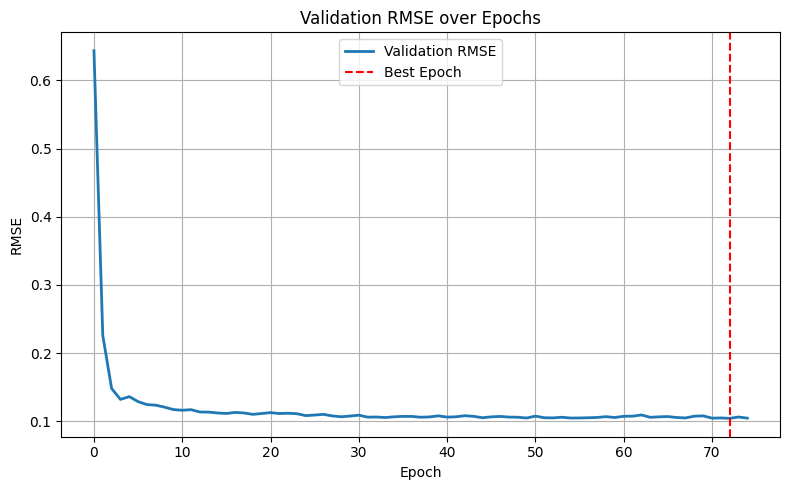

In [31]:
# 15. Plot validation RMSE over training epochs

# 15.1 Extract validation RMSE history from final model
val_rmse_list = final_model.history["val_0_rmse"]
loss_df = pd.DataFrame(val_rmse_list, columns=["val_rmse"])

# 15.2 Plot RMSE values across epochs
plt.figure(figsize=(8, 5))
plt.plot(loss_df["val_rmse"], label="Validation RMSE", linewidth=2)
plt.axvline(np.argmin(loss_df["val_rmse"]), color='red', linestyle='--', label="Best Epoch")

# 15.3 format the plot
plt.title("Validation RMSE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


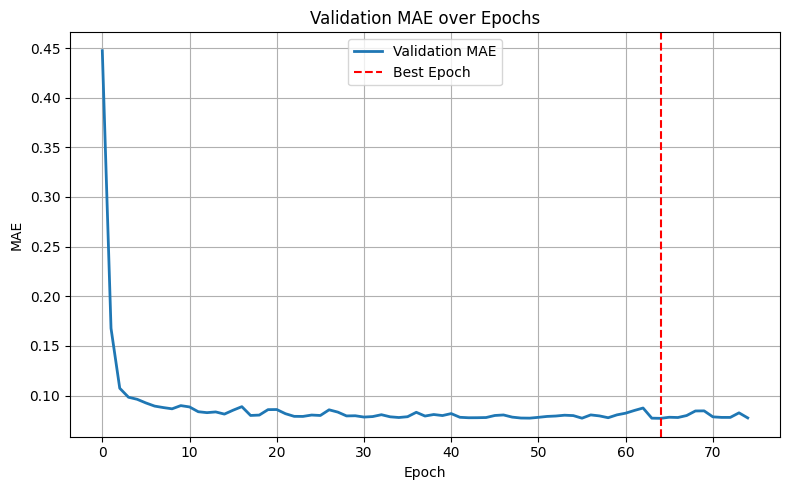

In [32]:
# 16. Plot validation MAE over training epochs

# 16.1 Extract validation MAE history
val_mae_list = final_model.history["val_0_mae"]
loss_df = pd.DataFrame(val_mae_list, columns=["val_mae"])

# 16.2 Create the MAE plot
plt.figure(figsize=(8, 5))
plt.plot(loss_df["val_mae"], label="Validation MAE", linewidth=2)
plt.axvline(np.argmin(loss_df["val_mae"]), color='red', linestyle='--', label="Best Epoch")

# 16.3 finalize the plot
plt.title("Validation MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


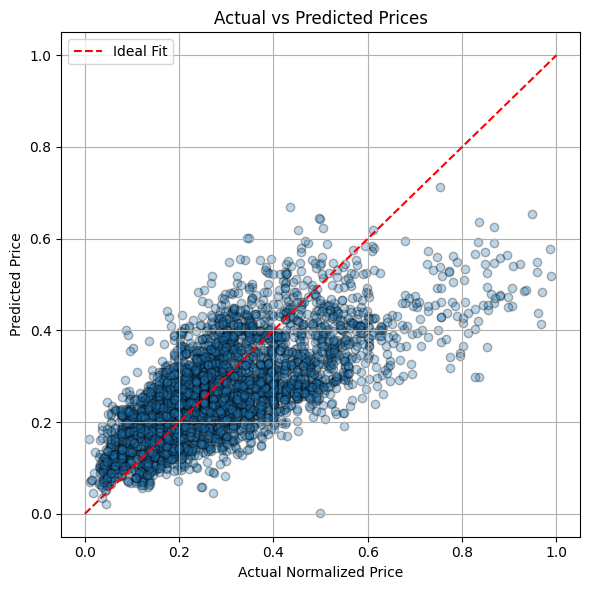

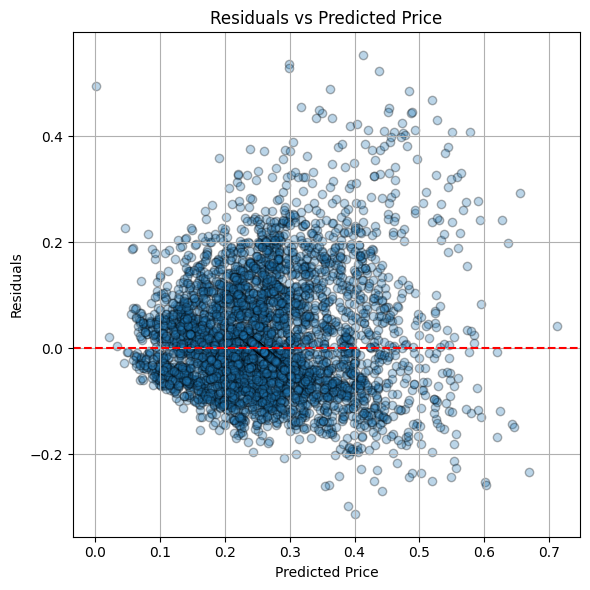

In [33]:
# 17. Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, preds, alpha=0.3, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--', label='Ideal Fit')
plt.xlabel("Actual Normalized Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 17. Residuals vs Predicted Plot
residuals = y_test - preds

plt.figure(figsize=(6, 6))
plt.scatter(preds, residuals, alpha=0.3, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Price")
plt.grid(True)
plt.tight_layout()
plt.show()


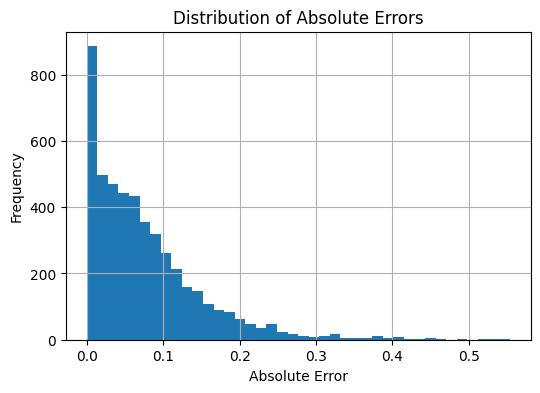

In [34]:
# 18 Plot absolute error distribution
errors = np.abs(y_test - preds)

plt.figure(figsize=(6, 4))
plt.hist(errors, bins=40)
plt.title("Distribution of Absolute Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


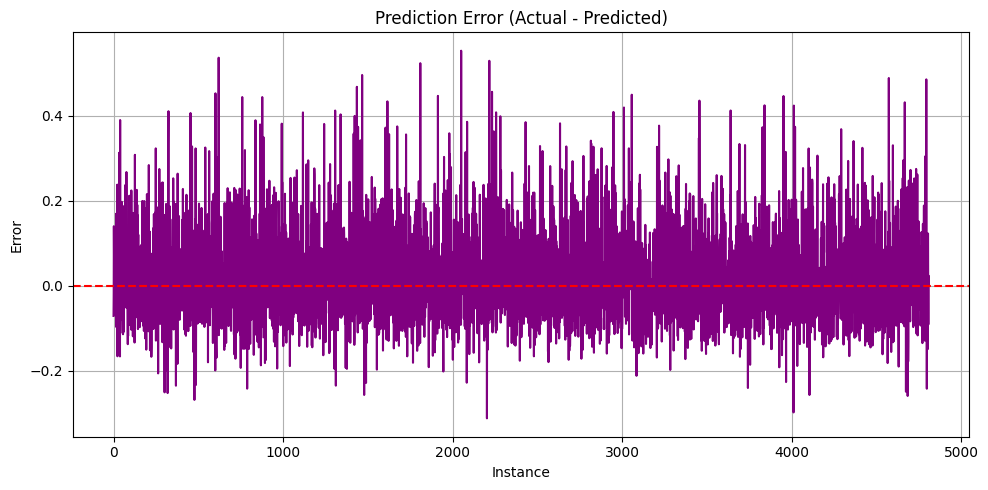

In [35]:
#19 Prediction Gap Plot (Difference line)
# Shows the difference between prediction and actual (like a time series gap):

diff = (y_test.flatten() - preds.flatten())

plt.figure(figsize=(10, 5))
plt.plot(diff, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error (Actual - Predicted)")
plt.xlabel("Instance")
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
plt.show()


### **End of Individual Component - tche0080 (TabNet)**

### Group Component 2

#### Optimal Model Comparison

- Structural Comparison of the three of the Optimal Models

Structurally, CatBoost and XGBoost are both gradient boosting tree-based models but differ in their treatment of categorical features and model complexity. CatBoost’s native support for categorical data reduces preprocessing burden, while XGBoost often requires one-hot or label encoding. This will increase the risk of dimensionality issues. On the other hand, TabNet uses a neural architecture with attention-based feature selection. While this enables TabNet to capture complex feature interactions, it also results in higher training time and lower interpretability. In contexts where model explainability is essential—such as pricing decisions communicated to stakeholders—XGBoost or CatBoost may be preferred despite similar performance metrics.

- Strengths and Limitations of Each Model

 CatBoostRegressor:

Strengths: Handles categorical features natively and low preprocessing requirements.  It is generally more robust with default parameters.

Limitations: Less interpretable compared to decision trees. Another one is that it has slower training time than simpler models.

Final Optimal Performance: MAE = 4855.83, R² score = 0.5344

XGBoost:

Strengths: Highly efficient and accurate and strong generalization capabilities. It is often the go-to model in tabular data competitions.

Limitations: Hyperparameter tuning is more complex. It is also sensitive to noise in small datasets.

Final Optimal Performance: MAE = 4770.90 (best among the three), R² score = 0.5624

TabNet:

Strengths: Deep learning model for tabular data with attention mechanisms; good for capturing nonlinear feature interactions.

Limitations: Requires significant computational resources, can overfit on small datasets. According to the result of TabNet model in this assignment, TabNet might be possibly more suitable to classification research problems more than regression problems such as we are predicting price in this assignment. 

Final Optimal Performance: MAE (rescaled) = 4885.83, R² score = 0.4844

- Quantitative and Qualitative Comparison

The bar chart below provides a quantitative comparison of the final Mean Absolute Error (MAE) across the three models:

While XGBoost achieved the lowest MAE, all models performed within a narrow error margin (~100 MAE difference). In terms of explanatory power, XGBoost achieved the highest R² score (0.5624), indicating that it explains approximately 56.24% of the variance in car prices — outperforming both CatBoost (0.5344) and TabNet (0.4844). While all models demonstrate moderate predictive capacity, XGBoost consistently ranks highest across both error-based metrics (MAE) and variance-explained metrics (R²), reinforcing its suitability for this regression task. Qualitatively, CatBoost required less feature engineering and was easier to implement, while TabNet offered deeper feature learning potential but was less practical due to compute overhead.

- Implications of Model Selection

The choice of model affects computational cost, interpretability, and real-world deployment. For example, XGBoost may be best for short-term implementation, but TabNet could be improved with more data and resources, and making it valuable for future scalability.

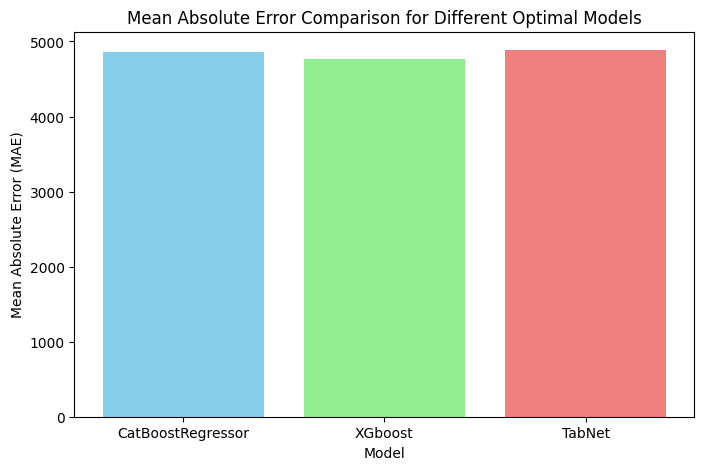

In [8]:
Final_MAE_dict = {
    'CatBoostRegressor':4855.83,
    'XGboost':4770.90,
    'TabNet':4885.83 # rescale by 0.0771*(68320-4950)
}

# Create a bar chart
models = list(Final_MAE_dict.keys())
mae_values = list(Final_MAE_dict.values())

plt.figure(figsize=(8, 5))
plt.bar(models, mae_values, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Mean Absolute Error Comparison for Different Optimal Models')
plt.show()

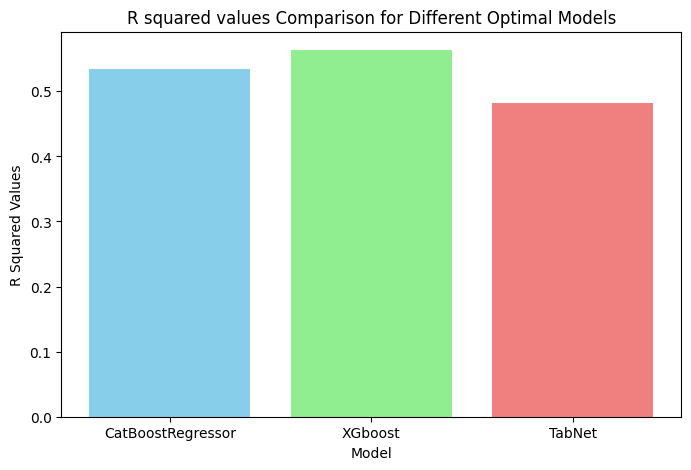

In [10]:
Final_R_Squared_dict = {
    'CatBoostRegressor':0.5344,
    'XGboost':0.5634,
    'TabNet':0.4824
}

# Create a bar chart
models = list(Final_R_Squared_dict.keys())
r_values = list(Final_R_Squared_dict.values())

plt.figure(figsize=(8, 5))
plt.bar(models, r_values, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.xlabel('Model')
plt.ylabel('R Squared Values')
plt.title('R squared values Comparison for Different Optimal Models')
plt.show()

#### Final Model Recommendation

Based on the evaluation, "XGBoost" is recommended as the most effective predictive model in this task.

Empirical Evidence: Lowest MAE = 4770.90 , Best R squared Metric = 0.5624

Theoretical Justification: Strong regularization, efficient tree boosting. XGBoost is recommended as the final model not only for its lowest MAE (4770.90) but also its highest R² (0.5624). XGBoost strongly demonstrates strong predictive accuracy and robustness in capturing the underlying structure of this specific dataset.

Domain Relevance: Well-suited for structured/tabular regression tasks like car price prediction

- Future Research Directions:

Data Collection: Increase dataset size and diversity to improve TabNet performance.

Model Refinement:

1. Perform hyperparameter tuning using Optuna or GridSearchCV.

2. Try ensemble models combining XGBoost and CatBoost.

3. Professional Collaboration: Work with domain experts (e.g., car valuation professionals) to select meaningful features or explore external factors affecting price.

### **End of Group Component 2**